# Persistence Landscapes and Machine Learning
---

This notebook gives usage examples for the persistence landscape functionality in `persim` and how they connect with other tools from `scikit-learn`. We will construct persistence landscapes for two different datasets (a sphere and a torus), plot them in comparison with each other, and use statistical learning tools to classify the two types of landscapes. 


**THIS IS A WORK IN PROGRESS, PLEASE ADD TO AND REVISE THIS!**

## Section 1: Example Plots for Torus vs Sphere
---

In this section, we plot persistence diagrams and persistence landscapes for a torus and a sphere to give a heuristic example before a larger-scale classification problem.

In [1]:
# Import general utilities
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Import TDA utilities
from ripser import Rips
from tadasets import torus, sphere
import persim

# Import Scikit-Learn tools
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
# Instantiate datasets
data_torus = torus(n=100, c=2, a=1)
data_sphere = sphere(n=100, r=2)

In [3]:
# Instantiate Vietoris-Rips solver
rips = Rips(maxdim = 2)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [4]:
# Compute persistence diagrams
dgms_torus = rips.fit_transform(data_torus)
dgms_sphere = rips.fit_transform(data_sphere)

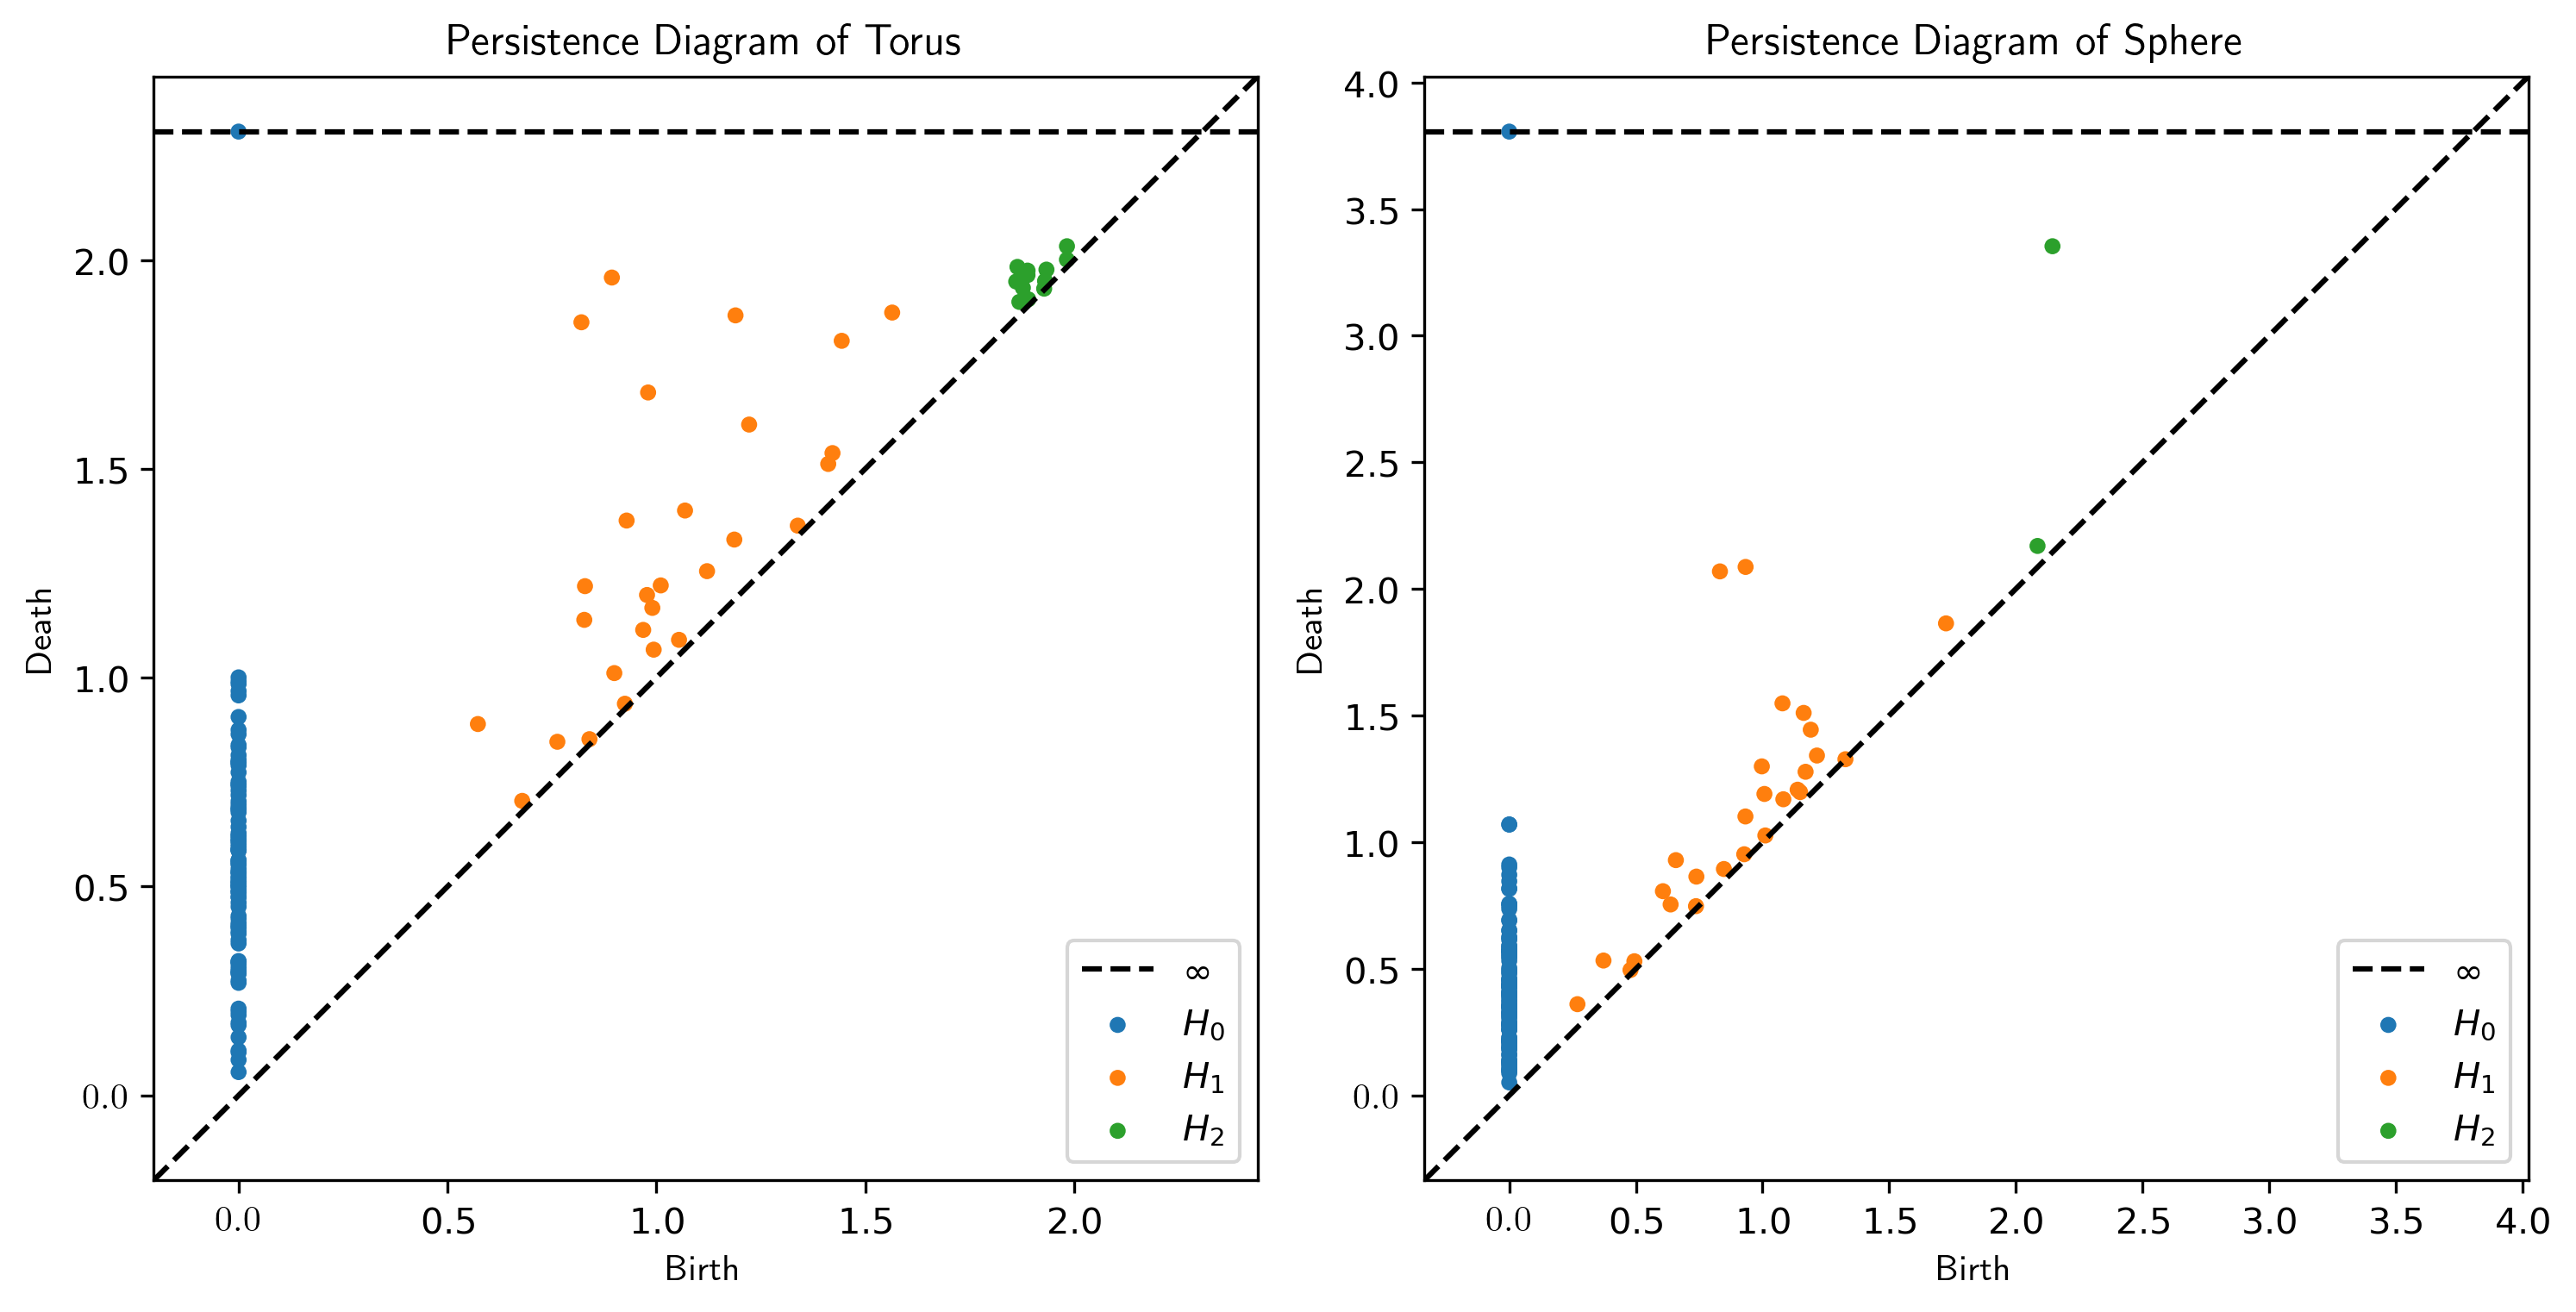

In [5]:
# Plot persistence diagrams
fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_size_inches(10, 5)

persim.plot_diagrams(dgms_torus, title="Persistence Diagram of Torus", ax=axs[0])

persim.plot_diagrams(dgms_sphere, title="Persistence Diagram of Sphere", ax=axs[1])

fig.tight_layout()

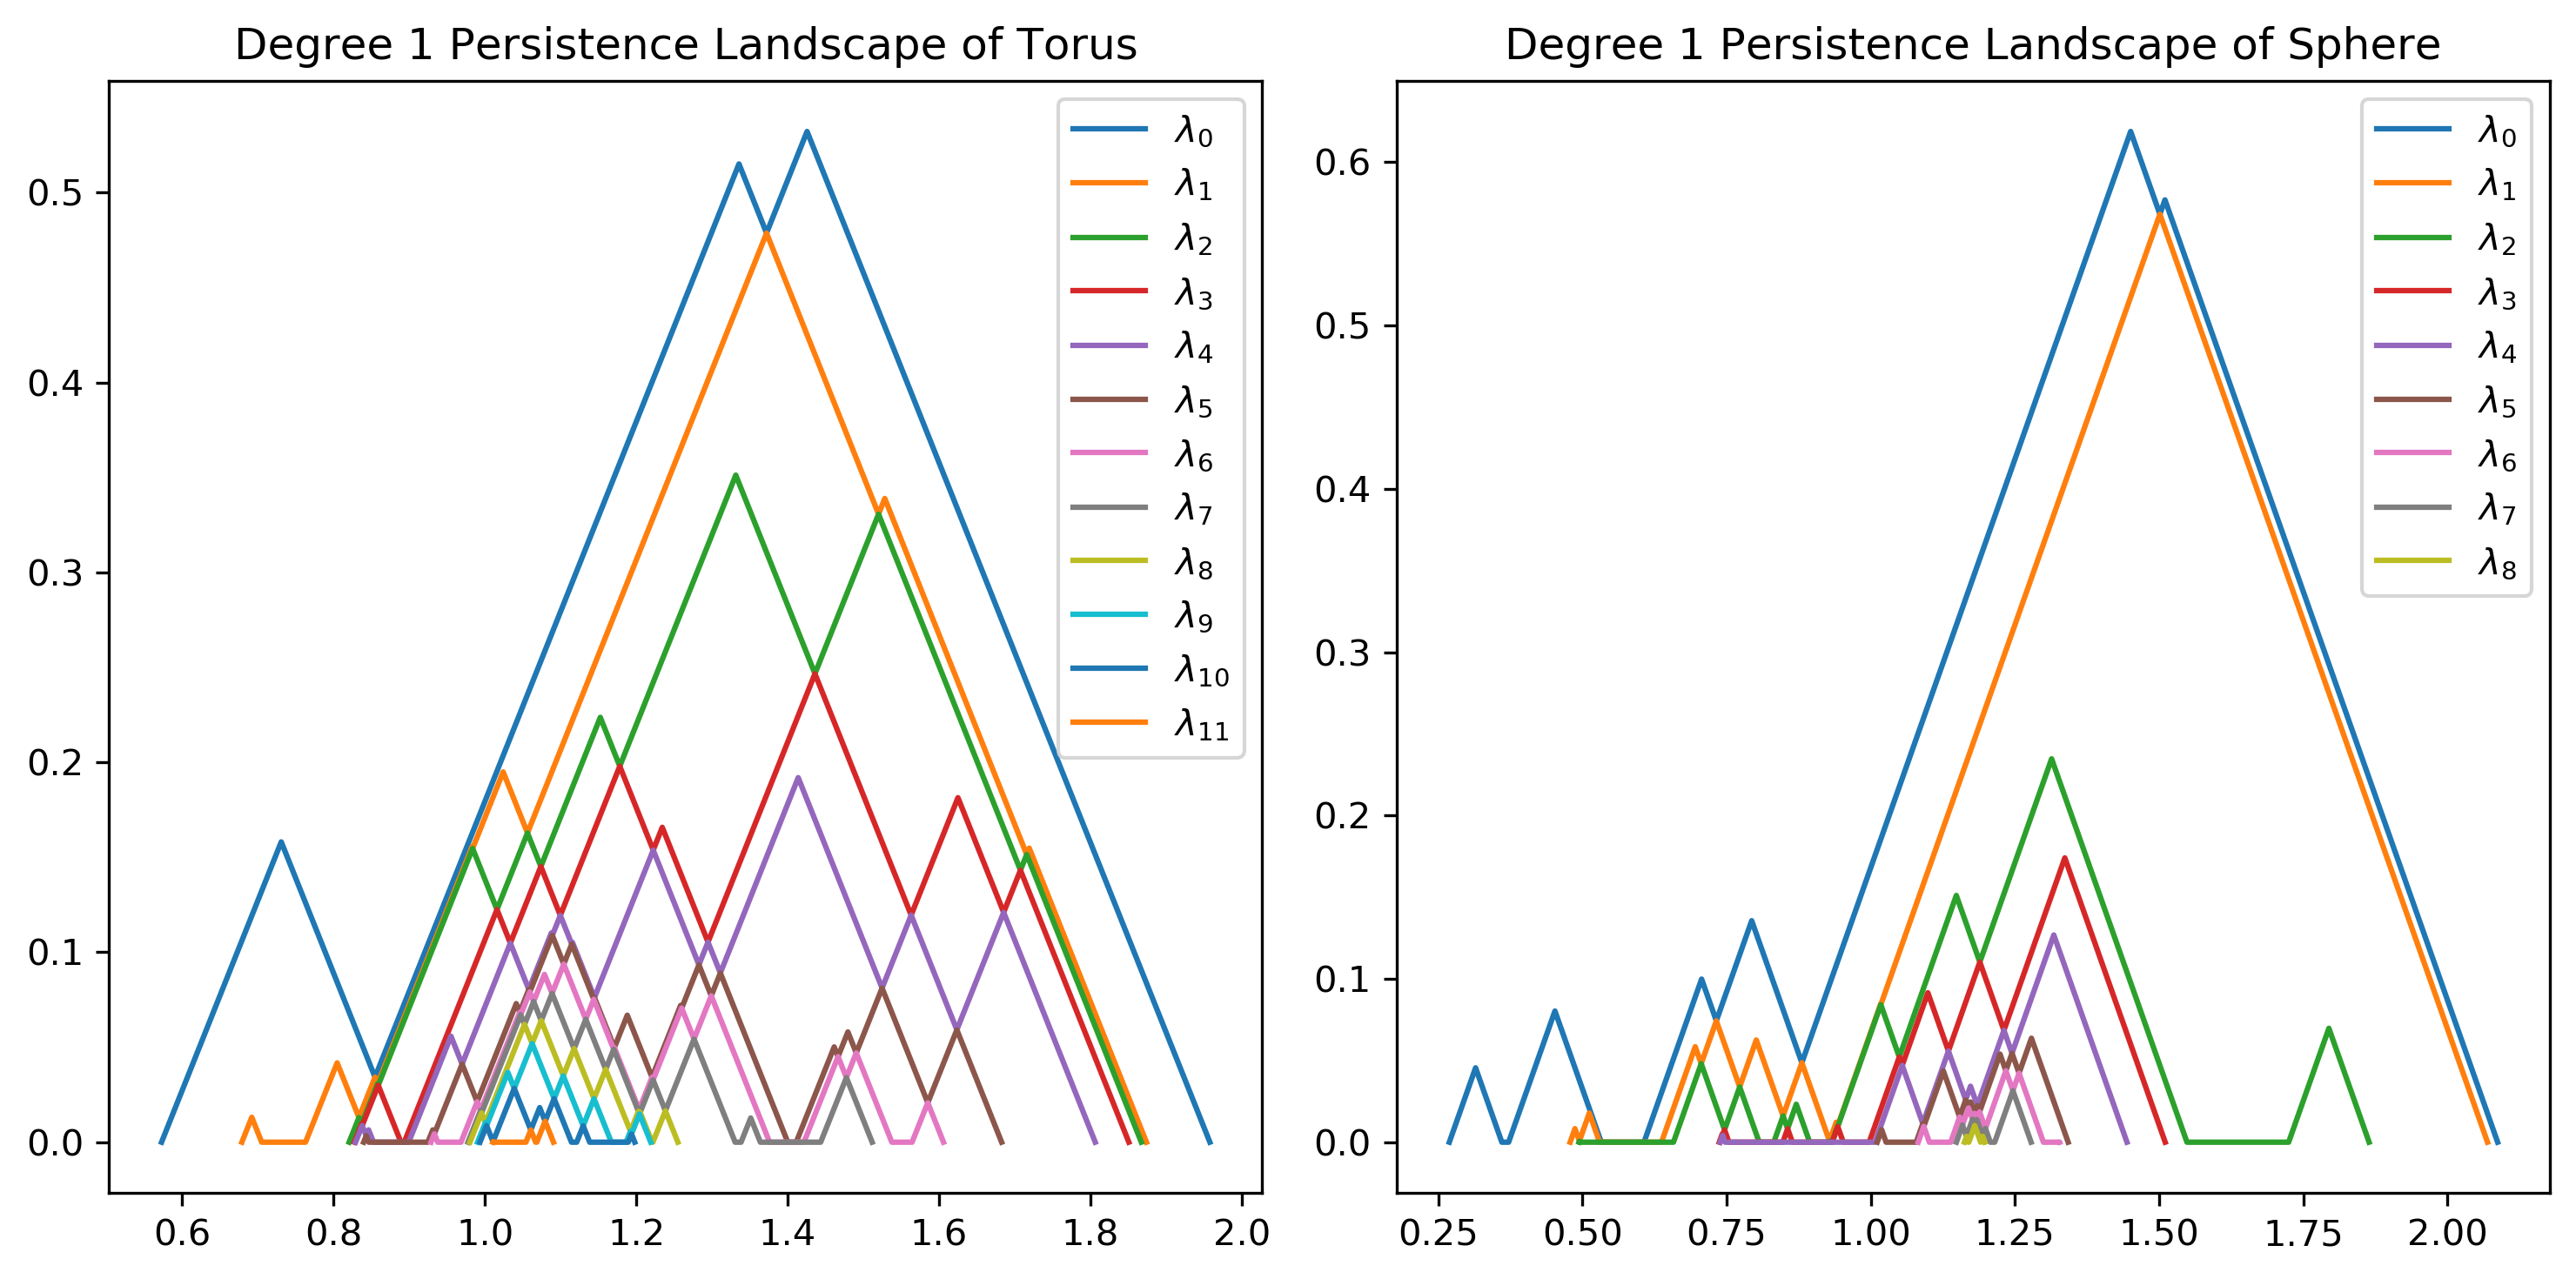

In [6]:
# Plot persistence landscapes
fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_size_inches(10, 5)

persim.plot_landscape_simple(persim.PersLandscapeExact(dgms_torus, hom_deg=1),
                             title="Degree 1 Persistence Landscape of Torus", ax=axs[0])

persim.plot_landscape_simple(persim.PersLandscapeExact(dgms_sphere, hom_deg=1),
                            title="Degree 1 Persistence Landscape of Sphere", ax=axs[1])

fig.tight_layout()

## Section 2: PCA and Classification
---

In this section, we construct a list of landscapes in degree 2, project down onto the first two principal components, and use linear support vector classification to determine which landscapes came from the torus and which came from the sphere.

In [7]:
# Compute multiple persistence landscapes

landscapes_torus = []
landscapes_sphere = []

for i in range(100):
    # Resample data
    _data_torus = torus(n=100, c=2, a=1)
    _data_sphere = sphere(n=100, r=2)
    
    # Compute persistence diagrams
    dgm_torus = rips.fit_transform(_data_torus)
    
    # Instantiate persistence landscape transformer
    torus_landscaper = persim.PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)
    
    # Compute flattened persistence landscape
    torus_flat = torus_landscaper.fit_transform(dgm_torus)
    
    landscapes_torus.append(torus_flat)
    
    # Compute persistence diagrams
    dgm_sphere = rips.fit_transform(_data_sphere)
    
    # Instantiate persistence landscape transformer
    sphere_landscaper = persim.PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)
    
    # Compute flattened persistence landscape
    sphere_flat = sphere_landscaper.fit_transform(dgm_sphere)
    
    landscapes_sphere.append(sphere_flat)   

print('Torus:', np.shape(landscapes_torus))
print('Sphere:', np.shape(landscapes_sphere))

Torus: (100,)
Sphere: (100,)


/home/calder/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In order to make this data interpretable by a PCA solver, we need a (N, M) matrix. As seen in the above print statements, each flattened landscape is not necessarily the same shape! This is because there may be different amounts of $\lambda_k$ functions for each resampling of the data. 

We can fix this by finding the maximal length `w` of a flattened landscape and zero-padding all flattened landscapes to maintain the same shape. 

In [8]:
# Find maximal length
u = np.max([len(a) for a in landscapes_torus])
v = np.max([len(a) for a in landscapes_sphere])

w = np.max([u,v])

# Instantiate zero-padded arrays
ls_torus = np.zeros((100, w))
ls_sphere = np.zeros((100, w))

# Populate arrays
for i in range(len(landscapes_torus)):
    ls_torus[i, 0:len(landscapes_torus[i])] = landscapes_torus[i]
    ls_sphere[i, 0:len(landscapes_sphere[i])] = landscapes_sphere[i]


print('Torus:', ls_torus.shape)
print('Sphere:', ls_sphere.shape)

Torus: (100, 9500)
Sphere: (100, 9500)


In [9]:
# Instantiate PCA solver
pca_torus = PCA(n_components=2)

# Compute PCA
pca_torus.fit_transform(ls_torus)

# Define components
comp_torus = pca_torus.components_

# Instantiate PCA solver
pca_sphere = PCA(n_components=2)

# Compute PCA
pca_sphere.fit_transform(ls_sphere)

# Define components
comp_sphere = pca_sphere.components_

We can understand the results of PCA using the singular values computed in the PCA process. 

In [10]:
print('Singular values for torus dataset:', pca_torus.singular_values_)
print('Singular values for sphere dataset:', pca_sphere.singular_values_)

Singular values for torus dataset: [10.86977382  8.25821531]
Singular values for sphere dataset: [10.43056549  9.63994952]


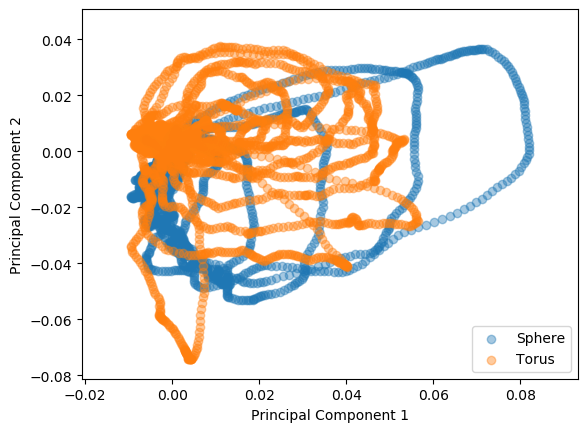

In [11]:
# Plot projection of data onto the first two principal components
plt.figure()
plt.scatter(comp_sphere[0], comp_sphere[1], label='Sphere', alpha=0.4)
plt.scatter(comp_torus[0], comp_torus[1], label='Torus', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

We now want to use a support vector classifier to classify between landscapes computed on a torus and landscapes computed on a sphere. To do so, we need a list of points $L$ and a function $f: L \to \{0, 1\}$ so that $f \equiv 0$ for torus landscapes and $f \equiv 1$ on sphere landscapes. 

In [12]:
# Produce lists of points
pts_torus = [[comp_torus[0,i], comp_torus[1,i]] for i in range(len(comp_torus[0]))]
pts_sphere = [[comp_sphere[0,i], comp_sphere[1,i]] for i in range(len(comp_sphere[0]))]

# Instantiate indicator functions
chi_torus = np.zeros(len(pts_torus))
chi_sphere = np.ones(len(pts_sphere))

# Produce final list of points
pts = []

for p in pts_torus:
    pts.append(p)
    
for p in pts_sphere:
    pts.append(p)

pts = np.array(pts)

# Append indicator functions
chi = np.hstack((chi_torus, chi_sphere))

To train the model, we use a simple 80-20 train/test split. In practice, this can be improved by using cross-validation or other such techniques.

In [13]:
# Split points and indicator arrays
P_train, P_test, c_train, c_test = train_test_split(pts, chi, train_size=.8)

# Instantiate support vector classifier
clf = svm.SVC()

# Fit model
clf.fit(P_train, c_train)

# Evaluate model performance using accuracy between ground truth data and predicted data
print(f'Model accuracy: {metrics.accuracy_score(c_test, clf.predict(P_test))}')

Model accuracy: 0.5802631578947368


## Section 3:  Improving Classification Accuracy
---

In this section, we go over some methods to improve the accuracy of the classification presented above. These methods include deleting highly persistent classes to identify significant differences in the data and using multicomponent PCA projections to capture more degrees of freedom in the initial data.


In [15]:
# Delete highly persistent landscapes

# Instantiate trimmed arrays
ls_torus_trim = ls_torus
ls_sphere_trim = ls_sphere

# Trim arrays
for i in range(len(landscapes_torus)):
    ls_torus_trim[i, 0:1000] = np.zeros((1000,))
    ls_sphere_trim[i, 0:1000] = np.zeros((1000,))


print('Torus:', ls_torus_trim.shape)
print('Sphere:', ls_sphere_trim.shape)


Torus: (100, 9500)
Sphere: (100, 9500)


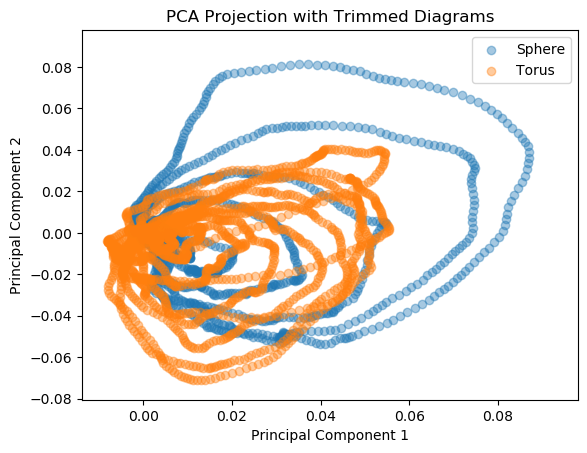

In [17]:
# Instantiate PCA solver
pca_torus_trim = PCA(n_components=2)

# Compute PCA
pca_torus_trim.fit_transform(ls_torus_trim)

# Define components
comp_torus_trim = pca_torus_trim.components_

# Instantiate PCA solver
pca_sphere_trim = PCA(n_components=2)

# Compute PCA
pca_sphere_trim.fit_transform(ls_sphere_trim)

# Define components
comp_sphere_trim = pca_sphere_trim.components_

# Plot projection of data onto the first two principal components
plt.figure()
plt.scatter(comp_sphere_trim[0], comp_sphere_trim[1], label='Sphere', alpha=0.4)
plt.scatter(comp_torus_trim[0], comp_torus_trim[1], label='Torus', alpha=0.4)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with Trimmed Diagrams')
plt.legend()

In [19]:
# Produce lists of points
pts_torus_trim = [[comp_torus_trim[0,i], comp_torus_trim[1,i]] for i in range(len(comp_torus_trim[0]))]
pts_sphere_trim = [[comp_sphere_trim[0,i], comp_sphere_trim[1,i]] for i in range(len(comp_sphere_trim[0]))]

# Instantiate indicator functions
chi_torus_trim = np.zeros(len(pts_torus_trim))
chi_sphere_trim = np.ones(len(pts_sphere_trim))

# Produce final list of points
pts_trim = []

for p in pts_torus_trim:
    pts_trim.append(p)
    
for p in pts_sphere_trim:
    pts_trim.append(p)

pts_trim = np.array(pts_trim)

# Append indicator functions
chi_trim = np.hstack((chi_torus_trim, chi_sphere_trim))

# Split points and indicator arrays
P_train_trim, P_test_trim, c_train_trim, c_test_trim = train_test_split(pts_trim, chi_trim, train_size=.8)

# Instantiate support vector classifier
clf_trim = svm.SVC()

# Fit model
clf_trim.fit(P_train_trim, c_train_trim)

# Evaluate model performance using accuracy between ground truth data and predicted data
print(f'Model accuracy: {metrics.accuracy_score(c_test_trim, clf_trim.predict(P_test_trim))}')

Model accuracy: 0.56


In [22]:
# Try multicomponent PCA

# Instantiate PCA solver
pca_torus_mcomp = PCA(n_components=6)

# Compute PCA
pca_torus_mcomp.fit_transform(ls_torus)

# Define components
comp_torus_mcomp = pca_torus_mcomp.components_

# Instantiate PCA solver
pca_sphere_mcomp = PCA(n_components=6)

# Compute PCA
pca_sphere_mcomp.fit_transform(ls_sphere)

# Define components
comp_sphere_mcomp = pca_sphere_mcomp.components_


# Produce lists of points
pts_torus_mcomp = [[comp_torus_mcomp[j,i] for j in range(6)] for i in range(len(comp_torus_mcomp[0]))]
pts_sphere_mcomp = [[comp_sphere_mcomp[j,i] for j in range(6)] for i in range(len(comp_sphere_mcomp[0]))]

# Instantiate indicator functions
chi_torus_mcomp = np.zeros(len(pts_torus_mcomp))
chi_sphere_mcomp = np.ones(len(pts_sphere_mcomp))

# Produce final list of points
pts_mcomp = []

for p in pts_torus_mcomp:
    pts_mcomp.append(p)
    
for p in pts_sphere_mcomp:
    pts_mcomp.append(p)

pts_mcomp = np.array(pts_mcomp)

# Append indicator functions
chi_mcomp = np.hstack((chi_torus_mcomp, chi_sphere_mcomp))

# Split points and indicator arrays
P_train_mcomp, P_test_mcomp, c_train_mcomp, c_test_mcomp = train_test_split(pts_mcomp, chi_mcomp, train_size=.8)

# Instantiate support vector classifier
clf_mcomp = svm.SVC()

# Fit model
clf_mcomp.fit(P_train_mcomp, c_train_mcomp)

# Evaluate model performance using accuracy between ground truth data and predicted data
print(f'Model accuracy: {metrics.accuracy_score(c_test_mcomp, clf_mcomp.predict(P_test_mcomp))}')


Model accuracy: 0.6126315789473684
